In [1]:
import requests, json, pandas as pd, matplotlib.pyplot as plt



def choose_force_neighborhood():
    
    '''This function calls the API and returns all the neighborhoods that fall within 
    the jurisdiction of the Sussex police(or any police entered into the url).
    
    Each neighborhood has an id code that will/can be used in the subsequent functions.'''
    
   
     #call the API to get Sussex police neighborhoods 
    
    resp_hoods=requests.get("https://data.police.uk/api/sussex/neighbourhoods")
    
    #print server response code 
    print(resp_hoods)

    #decode response as text/data
    if int(resp_hoods.status_code)==200:
        print(resp_hoods.text) 


In [2]:
choose_force_neighborhood()

<Response [200]>
[{"id":"CC1NH1","name":"Regency Business"},{"id":"CC1NH2","name":"North Laine"},{"id":"CC1NH3","name":"Regency Seafront"},{"id":"CC1NH4","name":"Seven Dials"},{"id":"CC1NH5","name":"Clifton, Montpelier, Powis"},{"id":"CC1NH6","name":"Triangle"},{"id":"CC1NH7","name":"London Road"},{"id":"CC1NH8","name":"Pankhurst"},{"id":"CC2NH2","name":"Viaduct"},{"id":"CC2NH22","name":"Craven Vale and Queensway"},{"id":"CC2NH23","name":"Bristol Estate"},{"id":"CC2NH3","name":"Tarner"},{"id":"CC2NH4","name":"Hanover"},{"id":"CC2NH5","name":"Queens Park"},{"id":"CC2NH6","name":"Elm Grove"},{"id":"CC2NH7","name":"Kemp Town - The Village"},{"id":"CC2NH8","name":"Kemp Town"},{"id":"CE1NH8","name":"Rottingdean and Coastal"},{"id":"CE1NH9","name":"Woodingdean"},{"id":"CE2NH1","name":"East Brighton"},{"id":"CE2NH10","name":"Hollingdean"},{"id":"CE2NH11","name":"Stanmer"},{"id":"CE2NH2","name":"Coldean"},{"id":"CE2NH3","name":"Tenantry"},{"id":"CE2NH4","name":"Meadowview"},{"id":"CE2NH5","nam

In [3]:
def neighborhood_boundaries():
    
    '''This function uses a particualr neighborhood's codes from the above function in the request url. 
    The request returns latitude and longitude coordinates for said neighborhood.
    
    Each neighborhood has pairs of latitude and longtitude coordinates that define
    its boundaries.
    
    For example, to search crimes stats for the town of East Brighton, enter its code (CE2NH1)
    into the url below.'''
    
    
    #call API to get latitude and longitude coordinates for a specific neighborhood
    resp_bound=requests.get("https://data.police.uk/api/sussex/CE2NH1/boundary")
    
    #print reponse code 
    print(resp_bound)
    
    #decode repsonse as text 
    if int(resp_bound.status_code)==200:
        #print('East Brighton: ',resp_bound.text)
        
        #turn response into json object
        coordinates=json.loads(resp_bound.text)
        
        return coordinates

In [28]:
def API_call(poly_string_date):
    
    '''This function takes in the coordinates from the neighborhood boundaries function,puts them 
    into the url and calls the API. Street crime data for those coordinates are returned.
    
    
    This function is also set up to call the API with 2 specific longitutde and latitude coordinates;
    This returns crime data within a 1-mile radius of the 2 coordinates.
    
    However, entering all the lat/long coordinates for neighborhood's boundary ensures it's the most 
    complete data available for a specific neighborhood (i.e. using only 2 or only some of the
    coordinates risks getting data for only part of the town (and its police force) or getting data
    for an area that overlaps into another force's jursidiction).
    
    The results are writtin to a json file to help future-proof the program in case something happens
    to the API, and to reduce the number of calls to the API and help avoid the risk of exceeding
    the data exchange rate limit.'''
    
    #pass in the coordinates via the function
    coordinates=neighborhood_boundaries()
    
    #loop through coordinates, putting lat. and long. values into a list 
    index=0
    poly_list=[]
    for item in coordinates:
        poly=(coordinates[index]['latitude'],coordinates[index]['longitude'])
        index+=1
        poly_list.append(poly)
    

    #flatten list of tuples (poly_list) into a single list of all values 
    single_list=([x for item in poly_list for x in item])
    
    #add colon to list for API url requirements 
    i=2
    while i<len(single_list):
        single_list.insert(i,':')
        i+=3
    
    #add comma to list for API url requirements 
    c=1
    while c<len(single_list):
        single_list.insert(c,',')
        c+=4
    
    #convert the list of coordinates into a string to function in a url 
    poly_string=""
    single_list_index=0
    for item in single_list:
        poly_string+=single_list[single_list_index]
        single_list_index+=1
        
   # create strings for API url requirements and concatenate for full url string 
    #poly_string1='poly='
    #poly_string2='&date='
    #poly_string_full=poly_string1+poly_string+poly_string2+poly_string_date
    #print(poly_string_full)
    poly_string1='&poly='
    poly_string2='date='
    #poly_string_full=poly_string1+poly_string+poly_string2+poly_string_date
    #print(poly_string_full)
    poly_string_full=poly_string2+poly_string_date+poly_string1+poly_string
    #create parameter variable so users can easily change specific coordinates
    #and dates when searching for a specific location (not an area with custom boundaries)
    lat_long= {'lat':'50.8261831655','lng':'-0.0861626297929','date':'2019-03'}
    #respo=requests.get("https://data.police.uk/api/crimes-street/all-crime?",params=lat_long)
    
    #insert custom area parameters into API request 
    respo=requests.get("https://data.police.uk/api/crimes-street/all-crime?",poly_string_full)
     
    #testing outcomes!!
    
    #respo=requests.get("https://data.police.uk/api/outcomes-at-location?",poly_string_full)
    #decode server response as text
    if int(respo.status_code)==200:
        respo_js=json.loads(respo.text)
        #print('json object:',respo_js)
        
        #create strings for variable json name
        file_start='crime_data_'
        file_end='.json'
        full_name=file_start+poly_string_date+file_end
        #open json file for writing
        with open(full_name,'w') as json_file:
            json.dump(respo_js,json_file)
        
        
    return respo_js
   

In [38]:
#API_call('2019-09')

In [30]:
def read_json(date):
    
    '''This function is used to read json files; it uses the parameter varable of the date
    to identify the approriate json file. '''
    
    #open json file for reading
    
    # #create strings for variable json name
    file_start='crime_data_'
    file_end='.json'
    full_name=file_start+date+file_end
        #open json file for writing
    with open(full_name,'r') as json_file:
        json_read=json.load(json_file)
        
    return json_read
    #print(json_read)

In [31]:
def crime_rates_analysis(date):
    
    '''This function takes in the the crime stats(in a json file) from a particular month,
    and counts the number of rows(crimes) and puts it into a new dataframe with the date
    and number of crimes(i.e. the crime rate)'''
    

    #read in json data with the function
    json_read=read_json(date)

    #get the month from the dataset to put into the dataframe of desired data (month and crime rate)
    month=json_read[0]['month']
    
    #get the length of the json file (i.e. # of crimes)
    rates=len(json_read)
    
    #put the above data (month and crime rates) into a list
    crime_rates=([month,rates])
    #put list into a dataframe
    crime_rates_df=pd.DataFrame(crime_rates)
    

    return crime_rates_df

In [32]:

def monthly_data_json():
    
    '''This function calls the API for the desired months to 
    get back all the desired data, and puts into json files.'''
    
    
    #call the API for each month and write each one to its own json file. 
    month1=API_call('2019-09')
    
    month2=API_call('2019-10')
    
    month3=API_call('2019-11')
    
    month4=API_call('2020-03')
  
    month5=API_call('2020-04')
    
    month6=API_call('2020-05')
   
    
    #print confirmation message
    print()
    print('Json files created.')

In [33]:
monthly_data_json()

<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>
<Response [200]>

Json files created.


In [34]:
def get_crime_rates():
    
    '''This functions calls the crime_rates_analysis function, which returns a dataframe of 
    that month's crime rate in a dataframe. All the dataframes are combined into a single 
    dataframe.'''
    
    cr1=crime_rates_analysis('2019-09')
    cr2=crime_rates_analysis('2019-10')
    cr3=crime_rates_analysis('2019-11')
    cr4=crime_rates_analysis('2020-03')
    cr5=crime_rates_analysis('2020-04')
    cr6=crime_rates_analysis('2020-05')
    
    full_df=pd.concat([cr1,cr2,cr3,cr4,cr5,cr6], axis=1,ignore_index=True)
    
    #return full dataframe 
    return full_df
    

In [35]:
def crime_rates_graph():
    
    '''This function takes in the dataframe of crime rates and plots it to a line graph.'''
    
    #pass in the dataframe
    full_df=get_crime_rates()
    #transpose the dataframe for plotting
    full_dft=full_df.T
    
    #add column names
    full_dft.columns=['Date','Crime Rate']
    #print(full_dft)
    #new_df=full_dft.style.set_properties(**{'text-align':'left'})
    #new_df=full_dft.style.set_properties(color='blue')
   # styler=new_df.set_table_styles([dict(selector='th',props=[('text-align','left')])])
    #print(new_df)
    
    full_dft.plot(x='Date',y='Crime Rate', kind='line')
  #  full_df.index=['Month','Street Crime Incidents']
    plt.ylabel('Number of Incidents')
    plt.title('Crime Rates Pre-and-Post COVID-19')
    
    plt.show()
    

In [44]:
from collections import Counter 

def data_search(date1,date2,date3,dict_key):
    
    '''This function reads in 3 json files, of whatever date the user chooses and puts them into a 
    single list. The user can also choose which data field to search (e.g. outcomes 
    or types of crimes). 
    
    The list is iterated through, filtering the desired results/data into its own list,which 
    is then coverted to a dataframe; insignficant numeric values are removed from the dataframe.
    
    API documentation does not clarify what 'None' means for the key 'outcome status'(e.g. if the outcome data is not available, if there is no
    data, or if an outcome has not been reached etc.). This data is still included in the final results
    as it makes up a significant portion of the results. '''
    
    #read in the json files. 
    month1=read_json(date1)
    month2=read_json(date2)
    month3=read_json(date3)
     
    #combine into a single list 
    total_months=month1+month2+month3
    
    
    #create empty list to hold outcome values and index variable to control the loop  
    values_list=[]
    index_var=0
    
    
    #loop through dataset
    for item in total_months:
        
        #test each outcome for 'nonetype'
        if dict_key=='outcome_status':
            
            #include 'none' value in the list of results
            if total_months[index_var]['outcome_status']is not None:
                
                values_list.append(total_months[index_var]['outcome_status']['category'])
                
            else:
            #if item is not None, put the type of outcome into a list 
                values_list.append(total_months[index_var]['outcome_status'])
            index_var+=1
           
        #allow the user to search for data other than 'outcome status'
        else:
            
            values_list.append(total_months[index_var][dict_key])
        #accumulate the index
            index_var+=1
            
    #print(values_list)
    #pass the list of outcomes to the counter dictionary
    values_counter=Counter(values_list)
   # print('the list',values_counter)
    
    #iterate through dictionary and put values into lists to avoid the value error
    #"if using scalar values must pass an index"
    for key in values_counter:
      
        values_counter[key]=([values_counter[key]])
   
    
    #pass the counter dictionary into dataframe
    values_df=pd.DataFrame(values_counter)
    
    
    #return and transpose the dataframe
    valuesdft=values_df.T
    valuesdft.columns=[dict_key+': 3-month Total']
    
    #remove insignificant numeric values and return 
    return valuesdft.loc[valuesdft[dict_key+': 3-month Total']>2]


In [51]:

data_search('2019-09','2019-10','2019-11','category')

,category: 3-month Total
anti-social-behaviour,66
bicycle-theft,4
burglary,13
criminal-damage-arson,26
other-theft,20
possession-of-weapons,4
public-order,18
shoplifting,6
vehicle-crime,24
violent-crime,121


In [56]:
def analytics_graph(date1,date2,date3,search_item):

    '''This function gets 3 months of a particular field of data. It measures/visualizes the 
    data in a pie chart. 
    '''
    #pass in the dataframe and data field 
    results=data_search(date1,date2,date3,search_item)
    
    #plot to a pie chart 
    results.plot(kind='pie',y=0 ,autopct='%.1f',label='',textprops={'fontsize':43},legend=False,figsize=(35,35))
    title=search_item+': '+date1+', '+date2+', '+date3
    plt.title('Crime '+title, fontsize=50)
    plt.show()
    

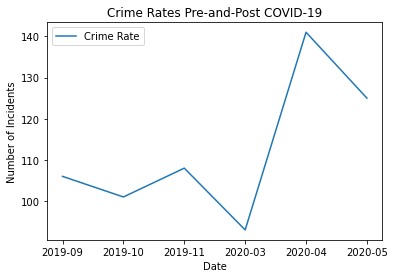

In [57]:
crime_rates_graph()


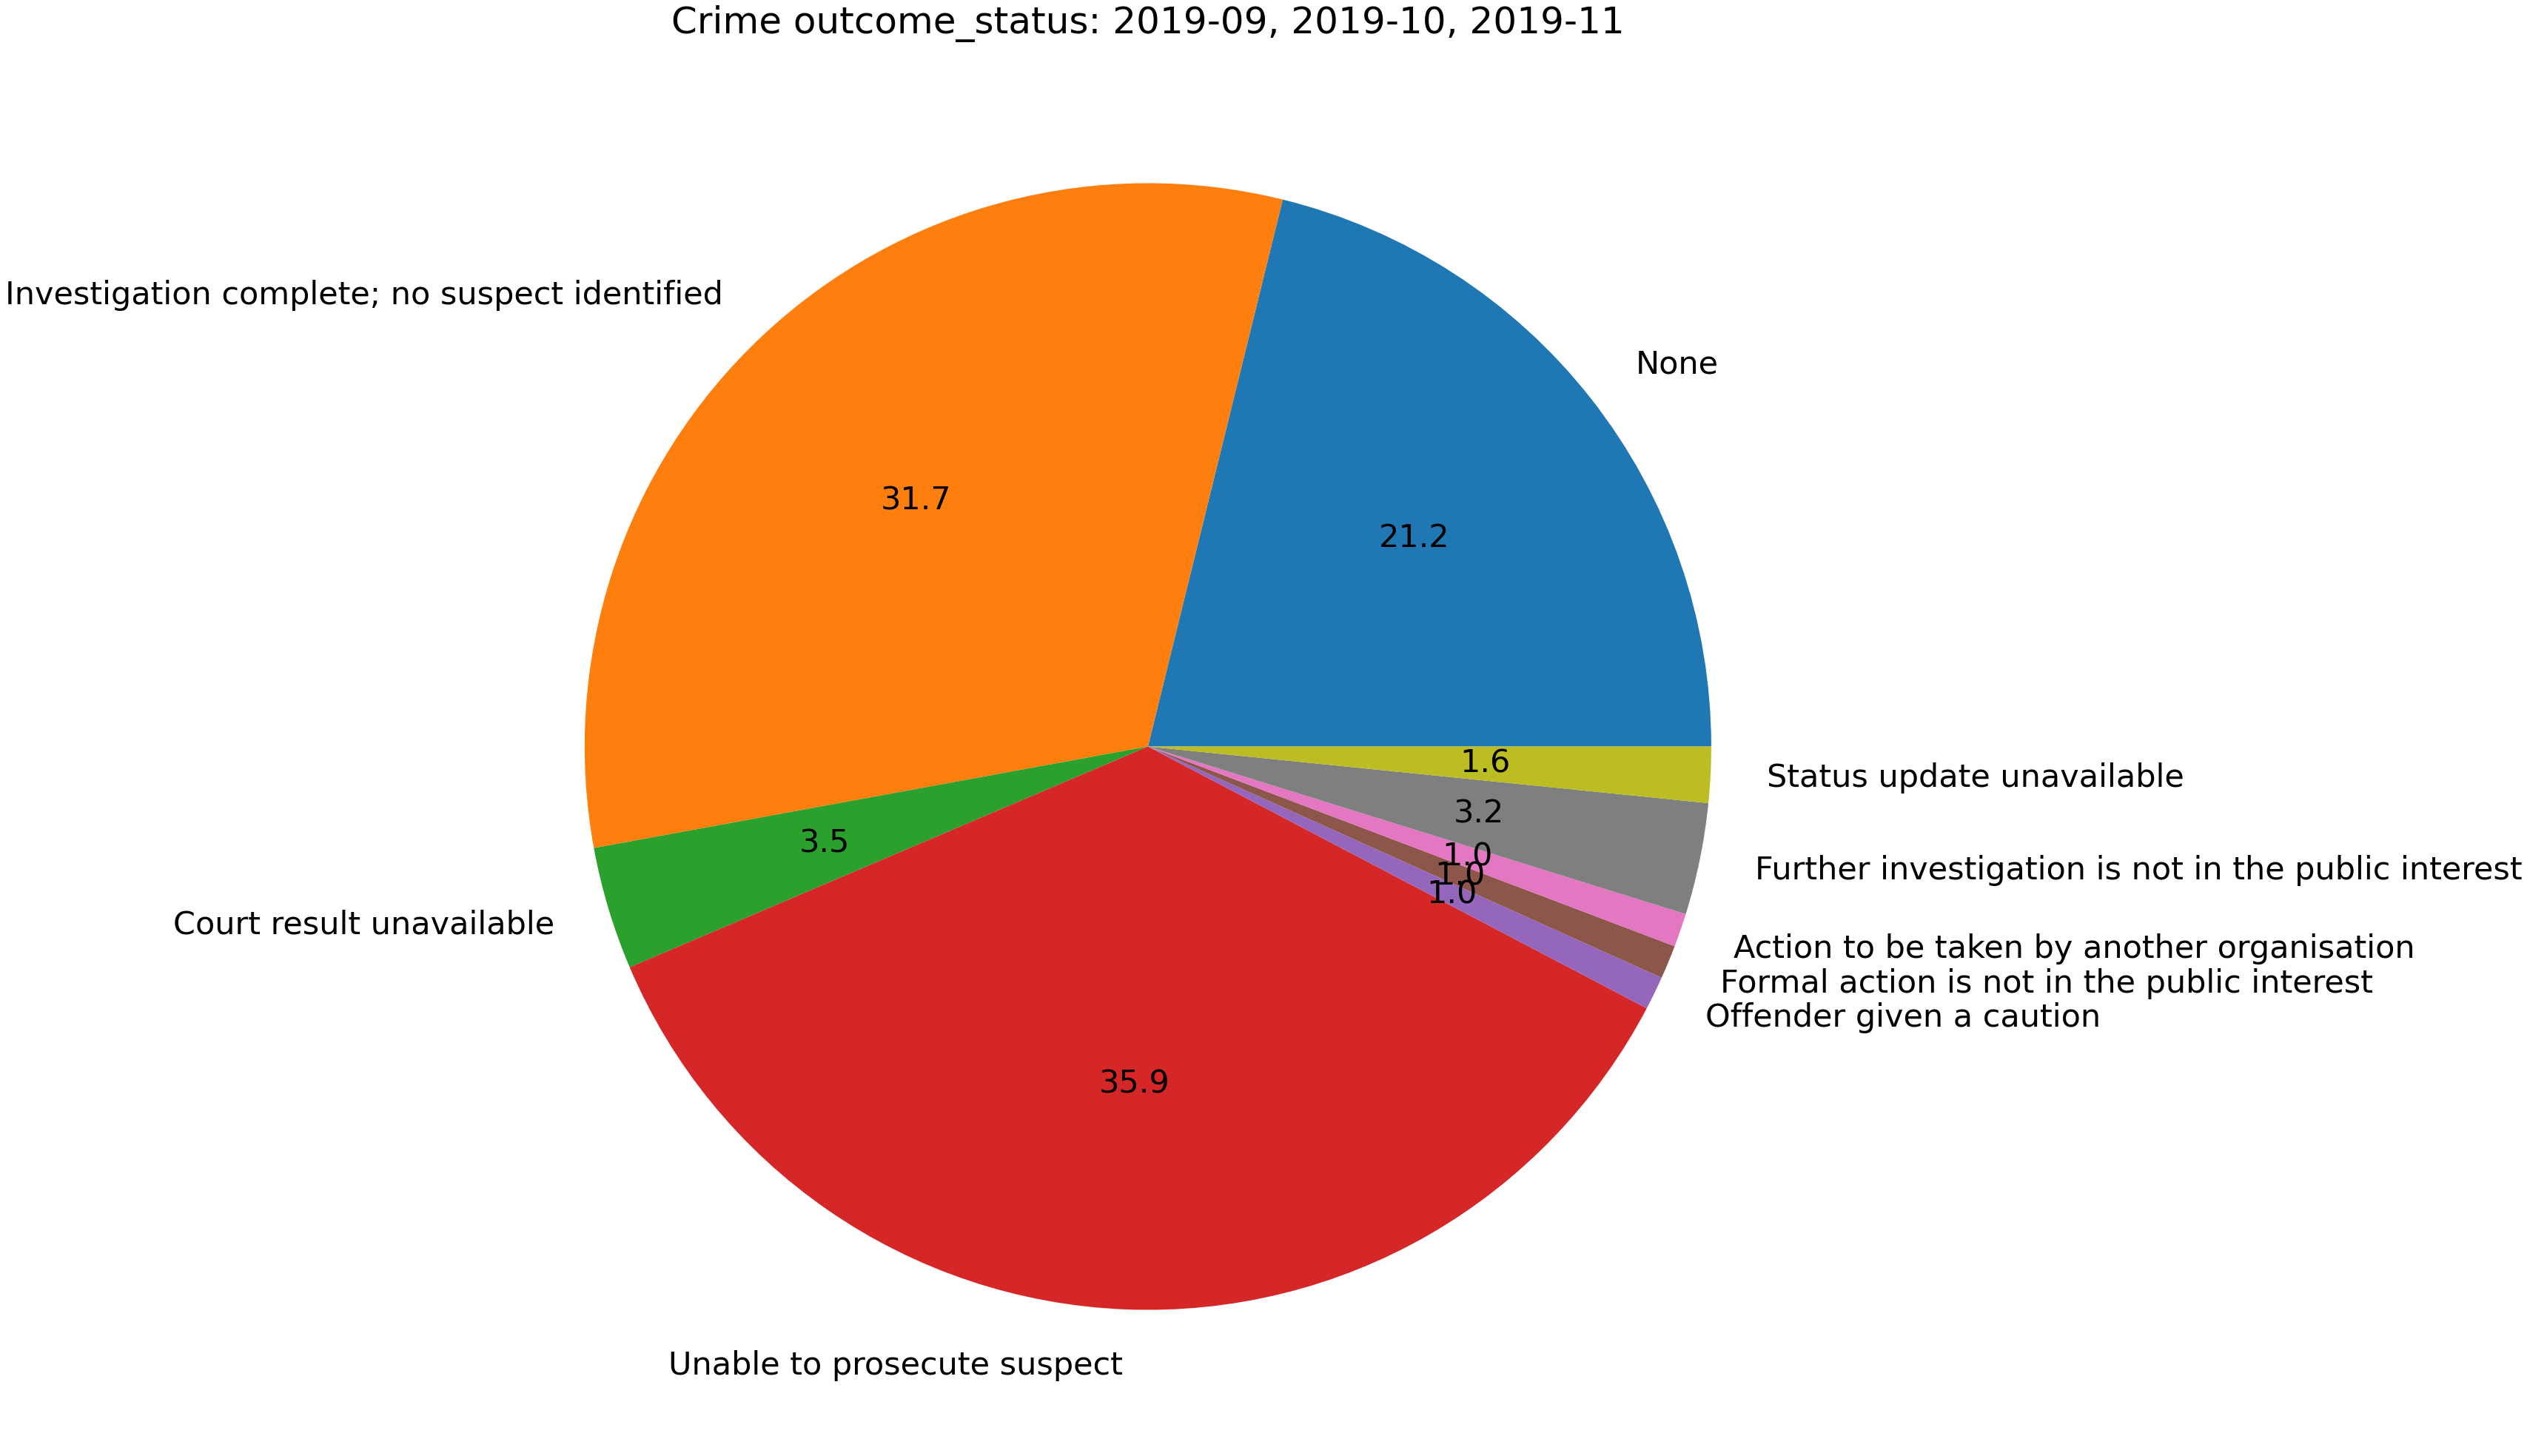

In [58]:
analytics_graph('2019-09','2019-10','2019-11','outcome_status')



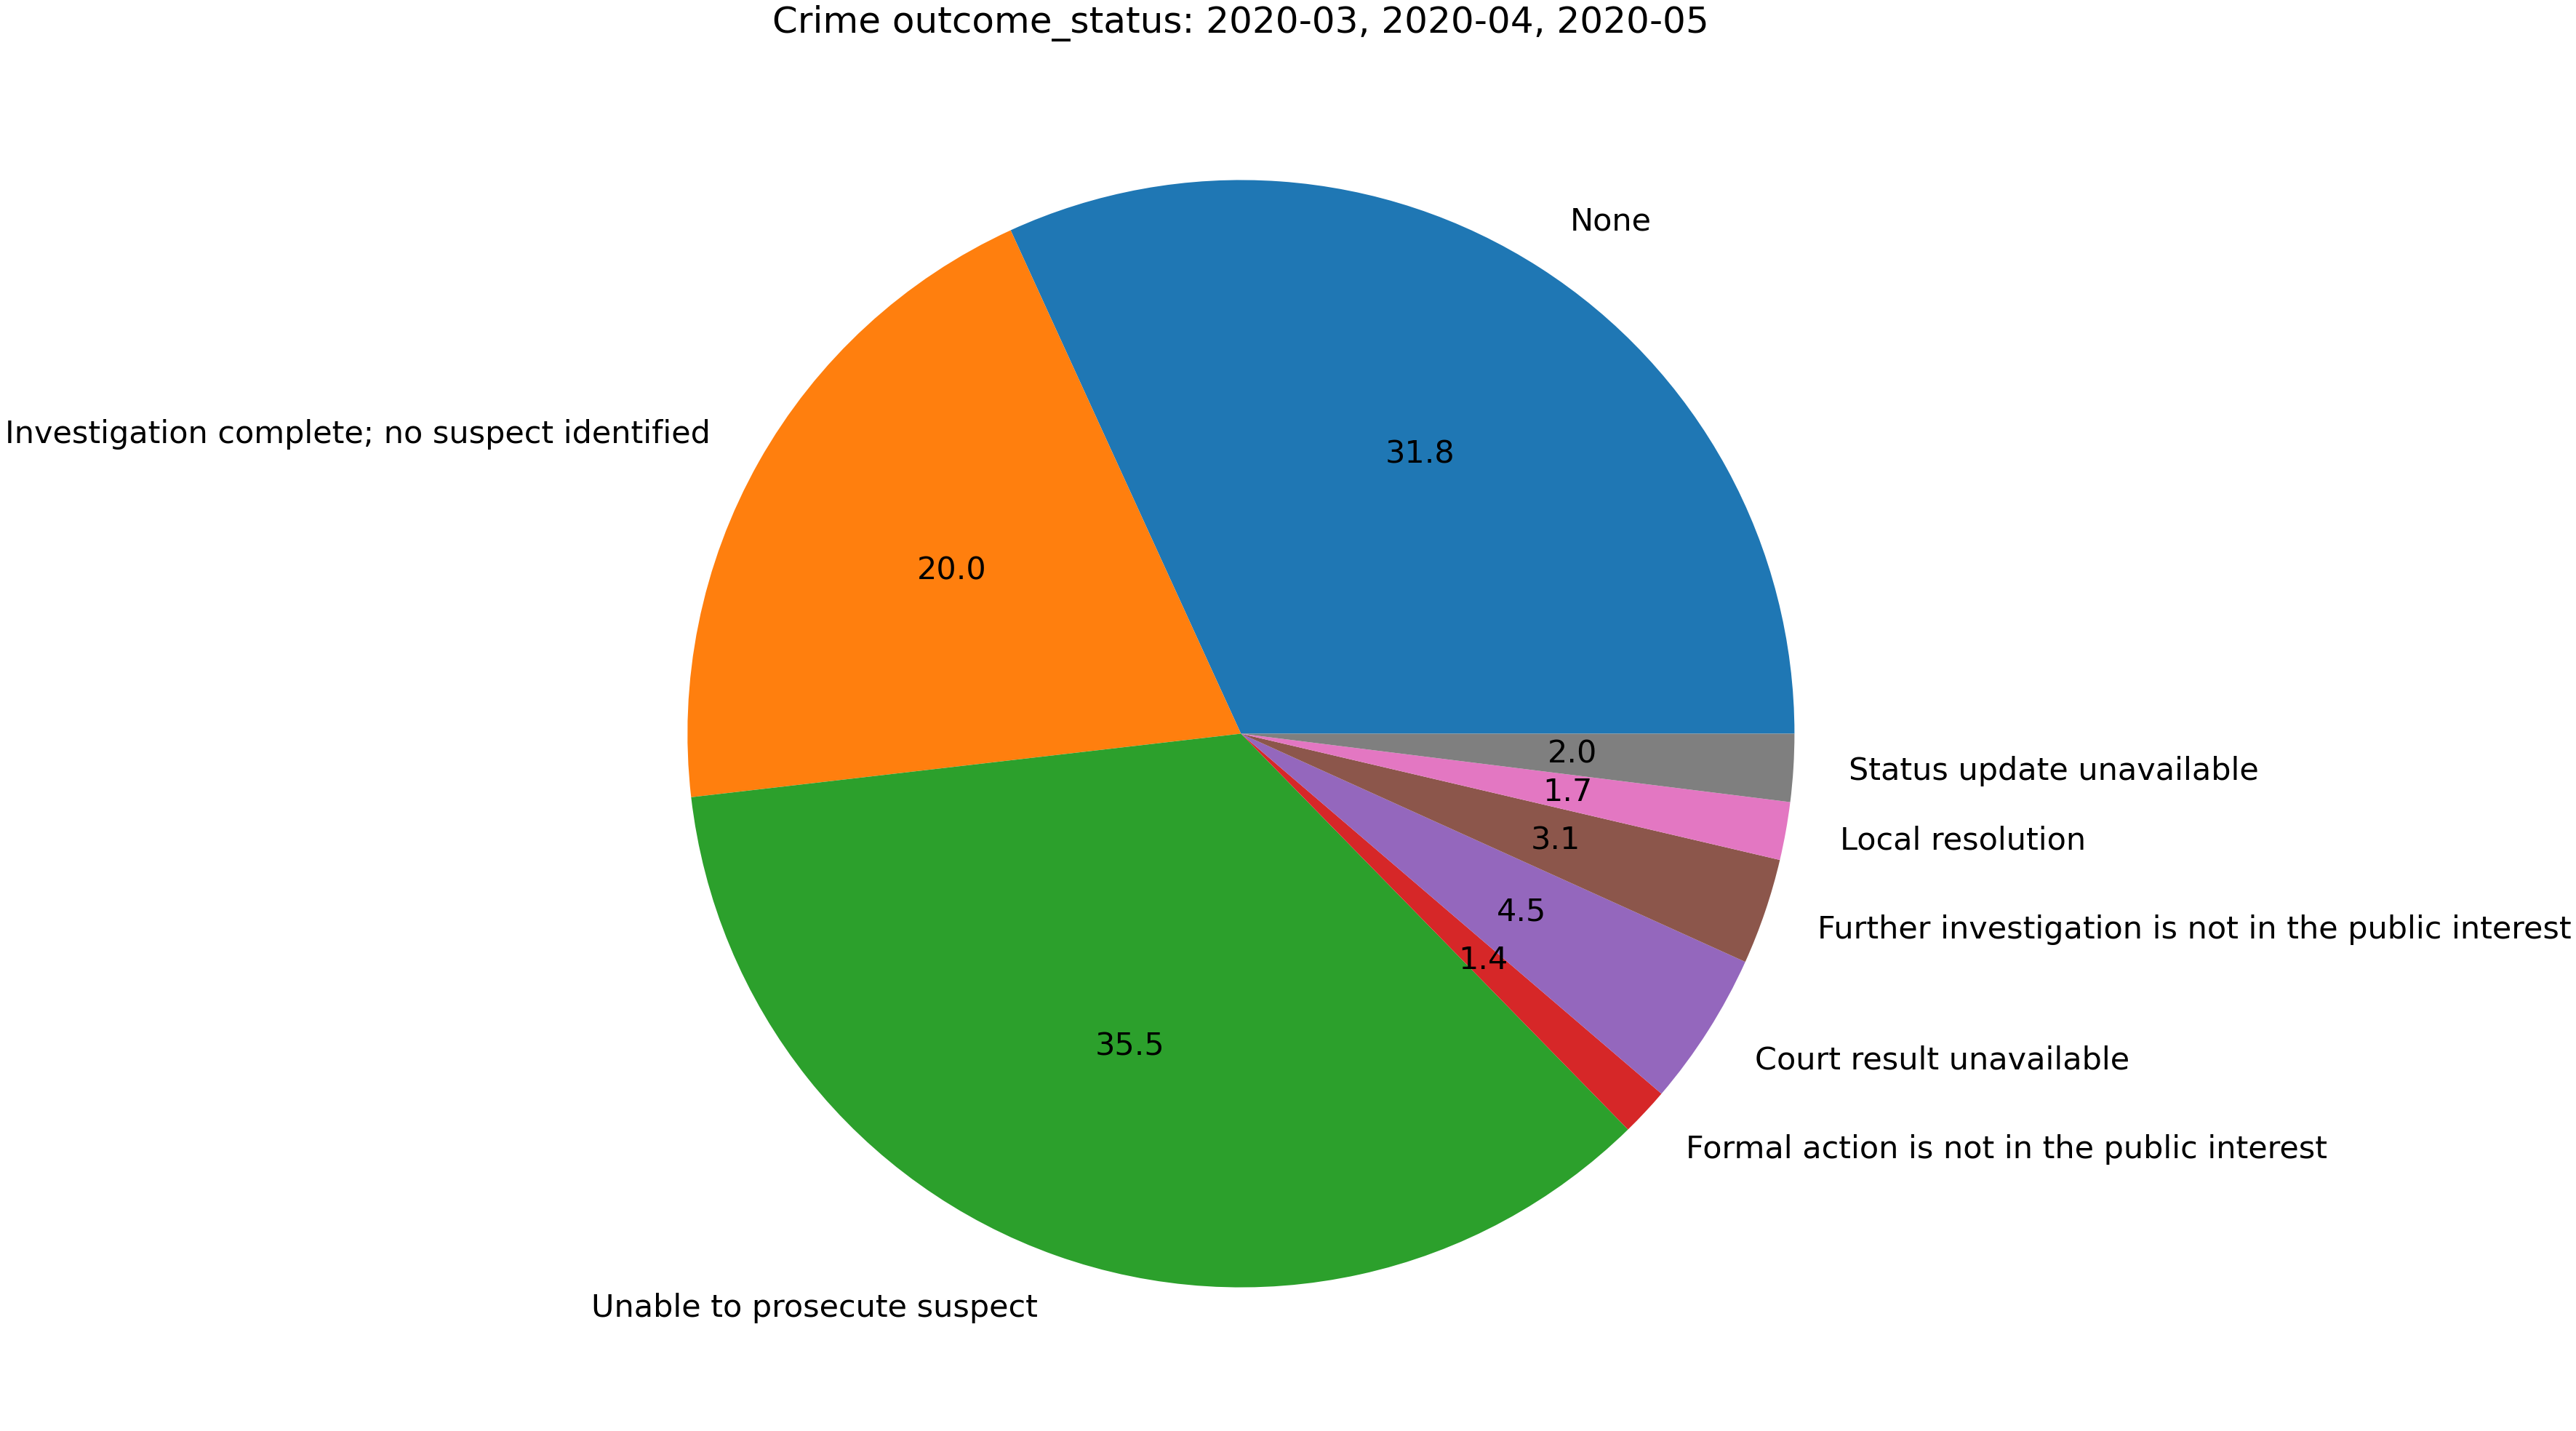

In [59]:
analytics_graph('2020-03','2020-04','2020-05','outcome_status')



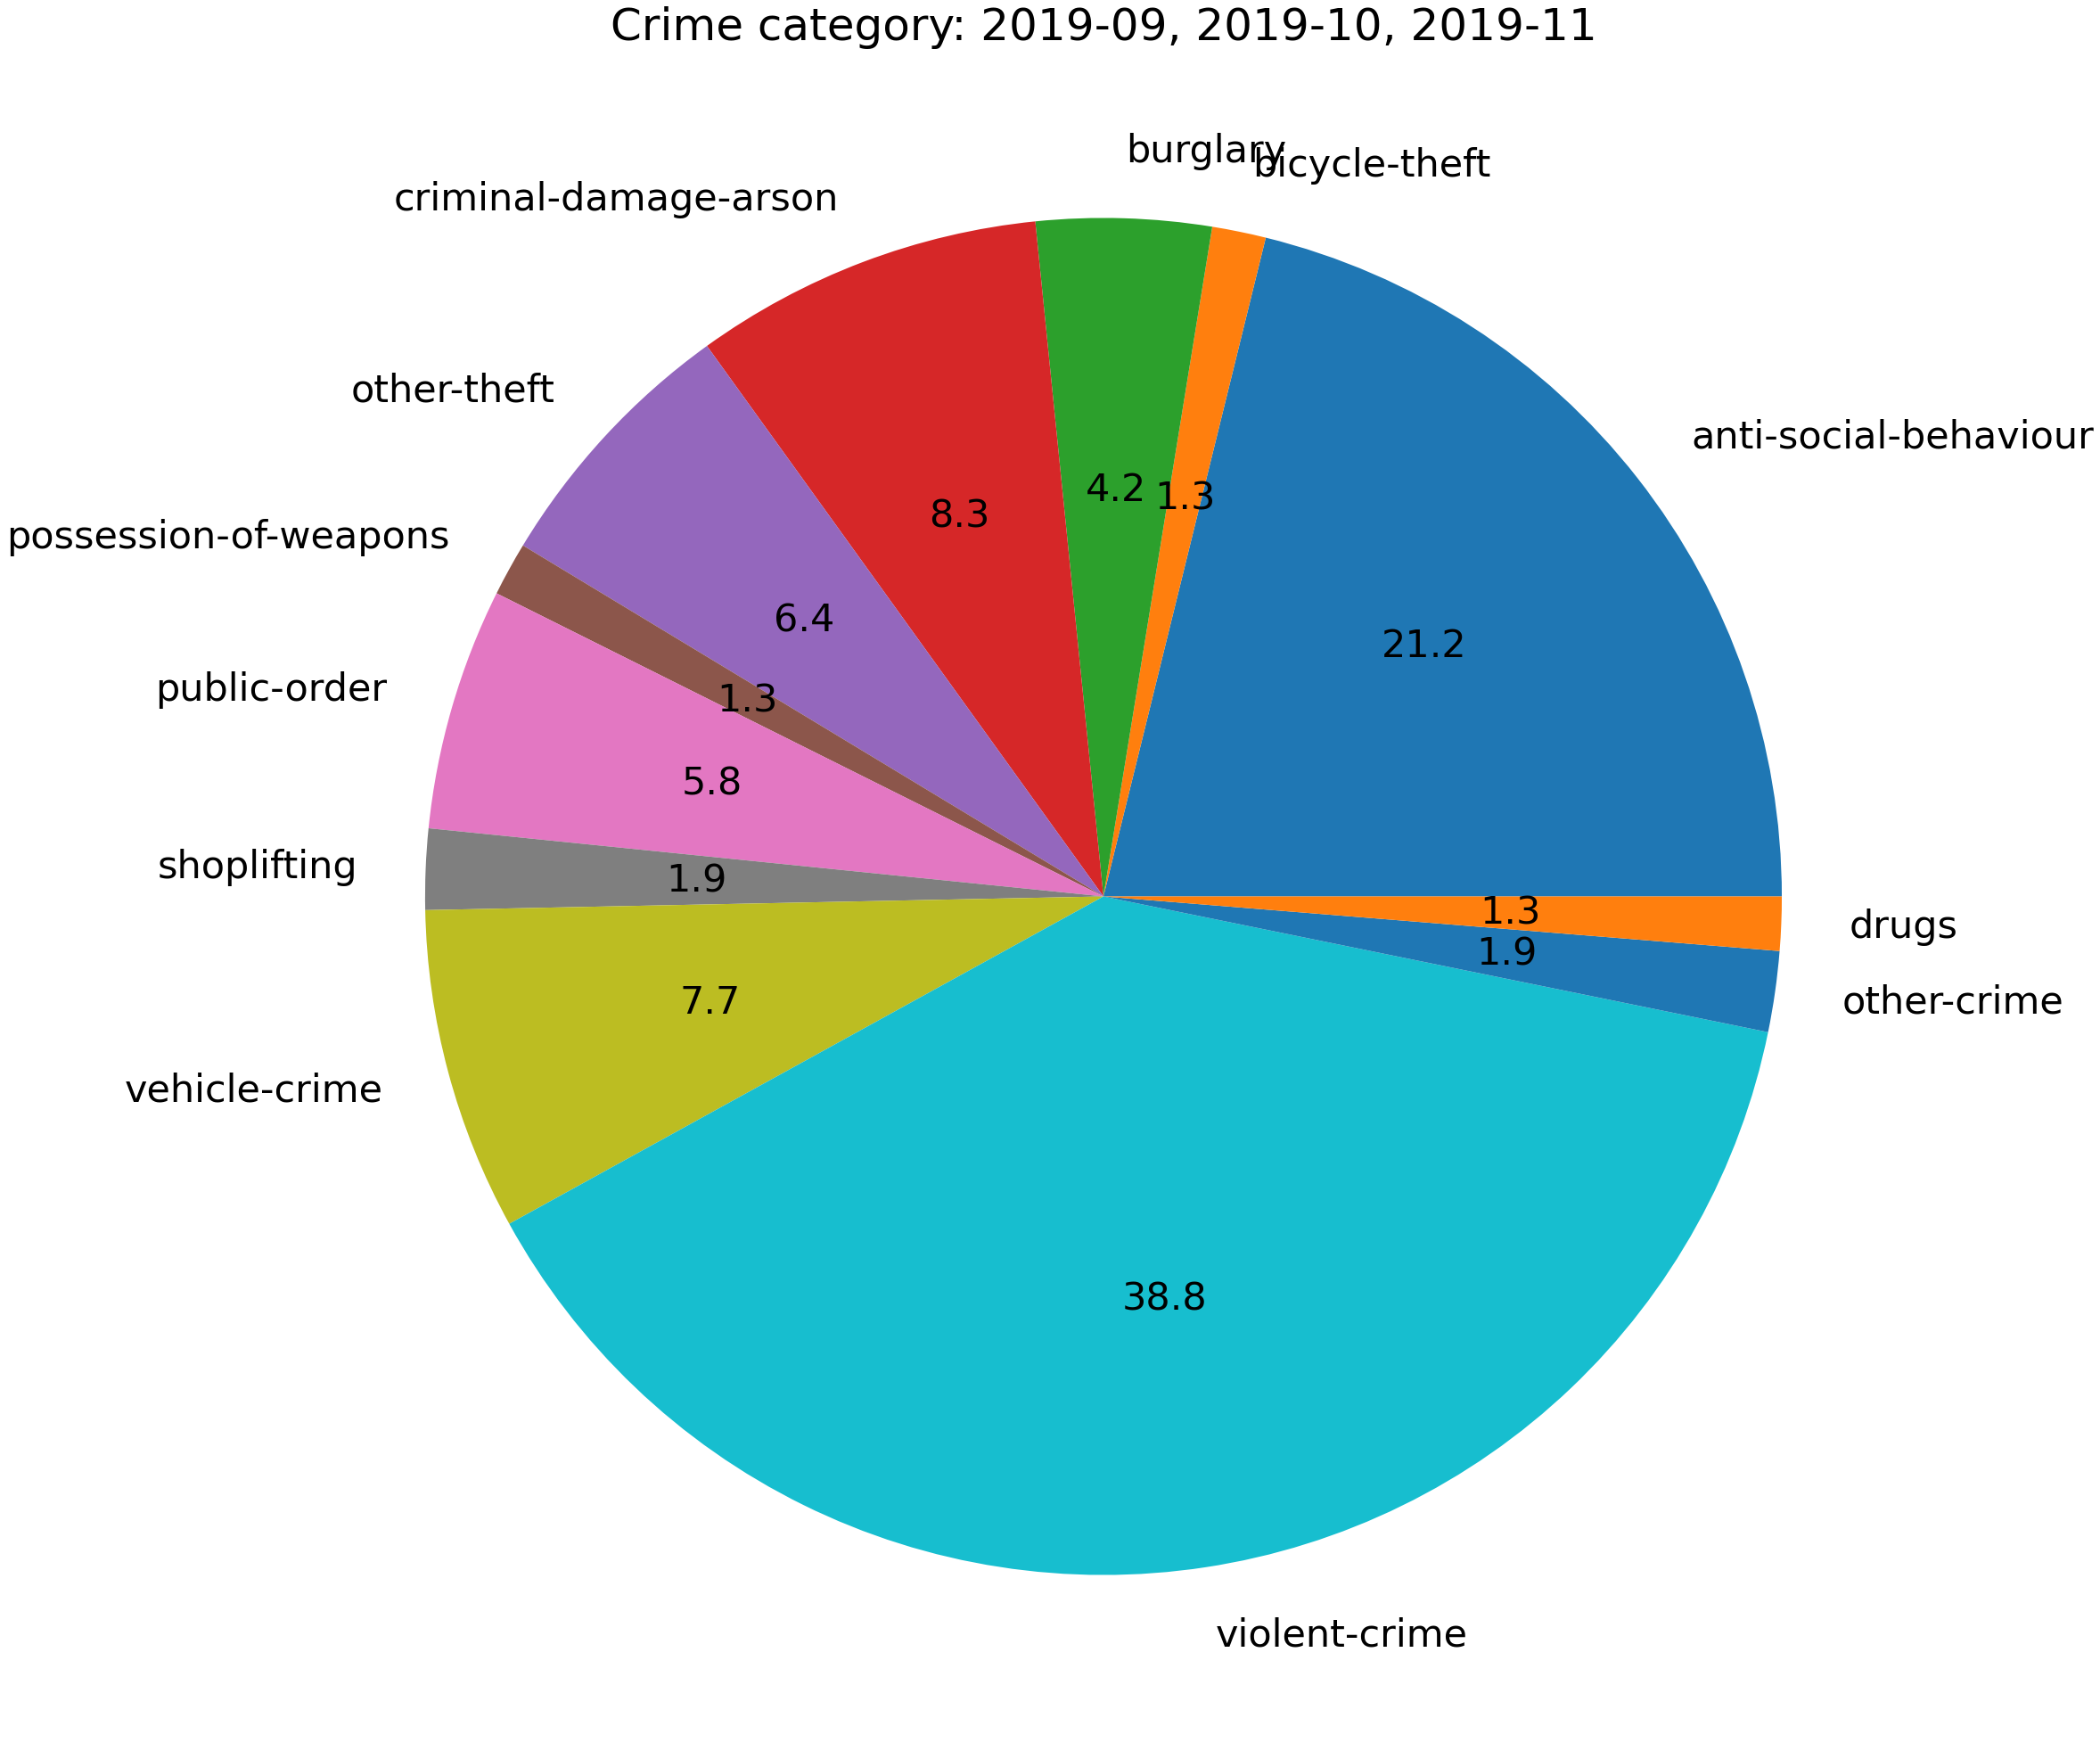

In [60]:
analytics_graph('2019-09','2019-10','2019-11','category')


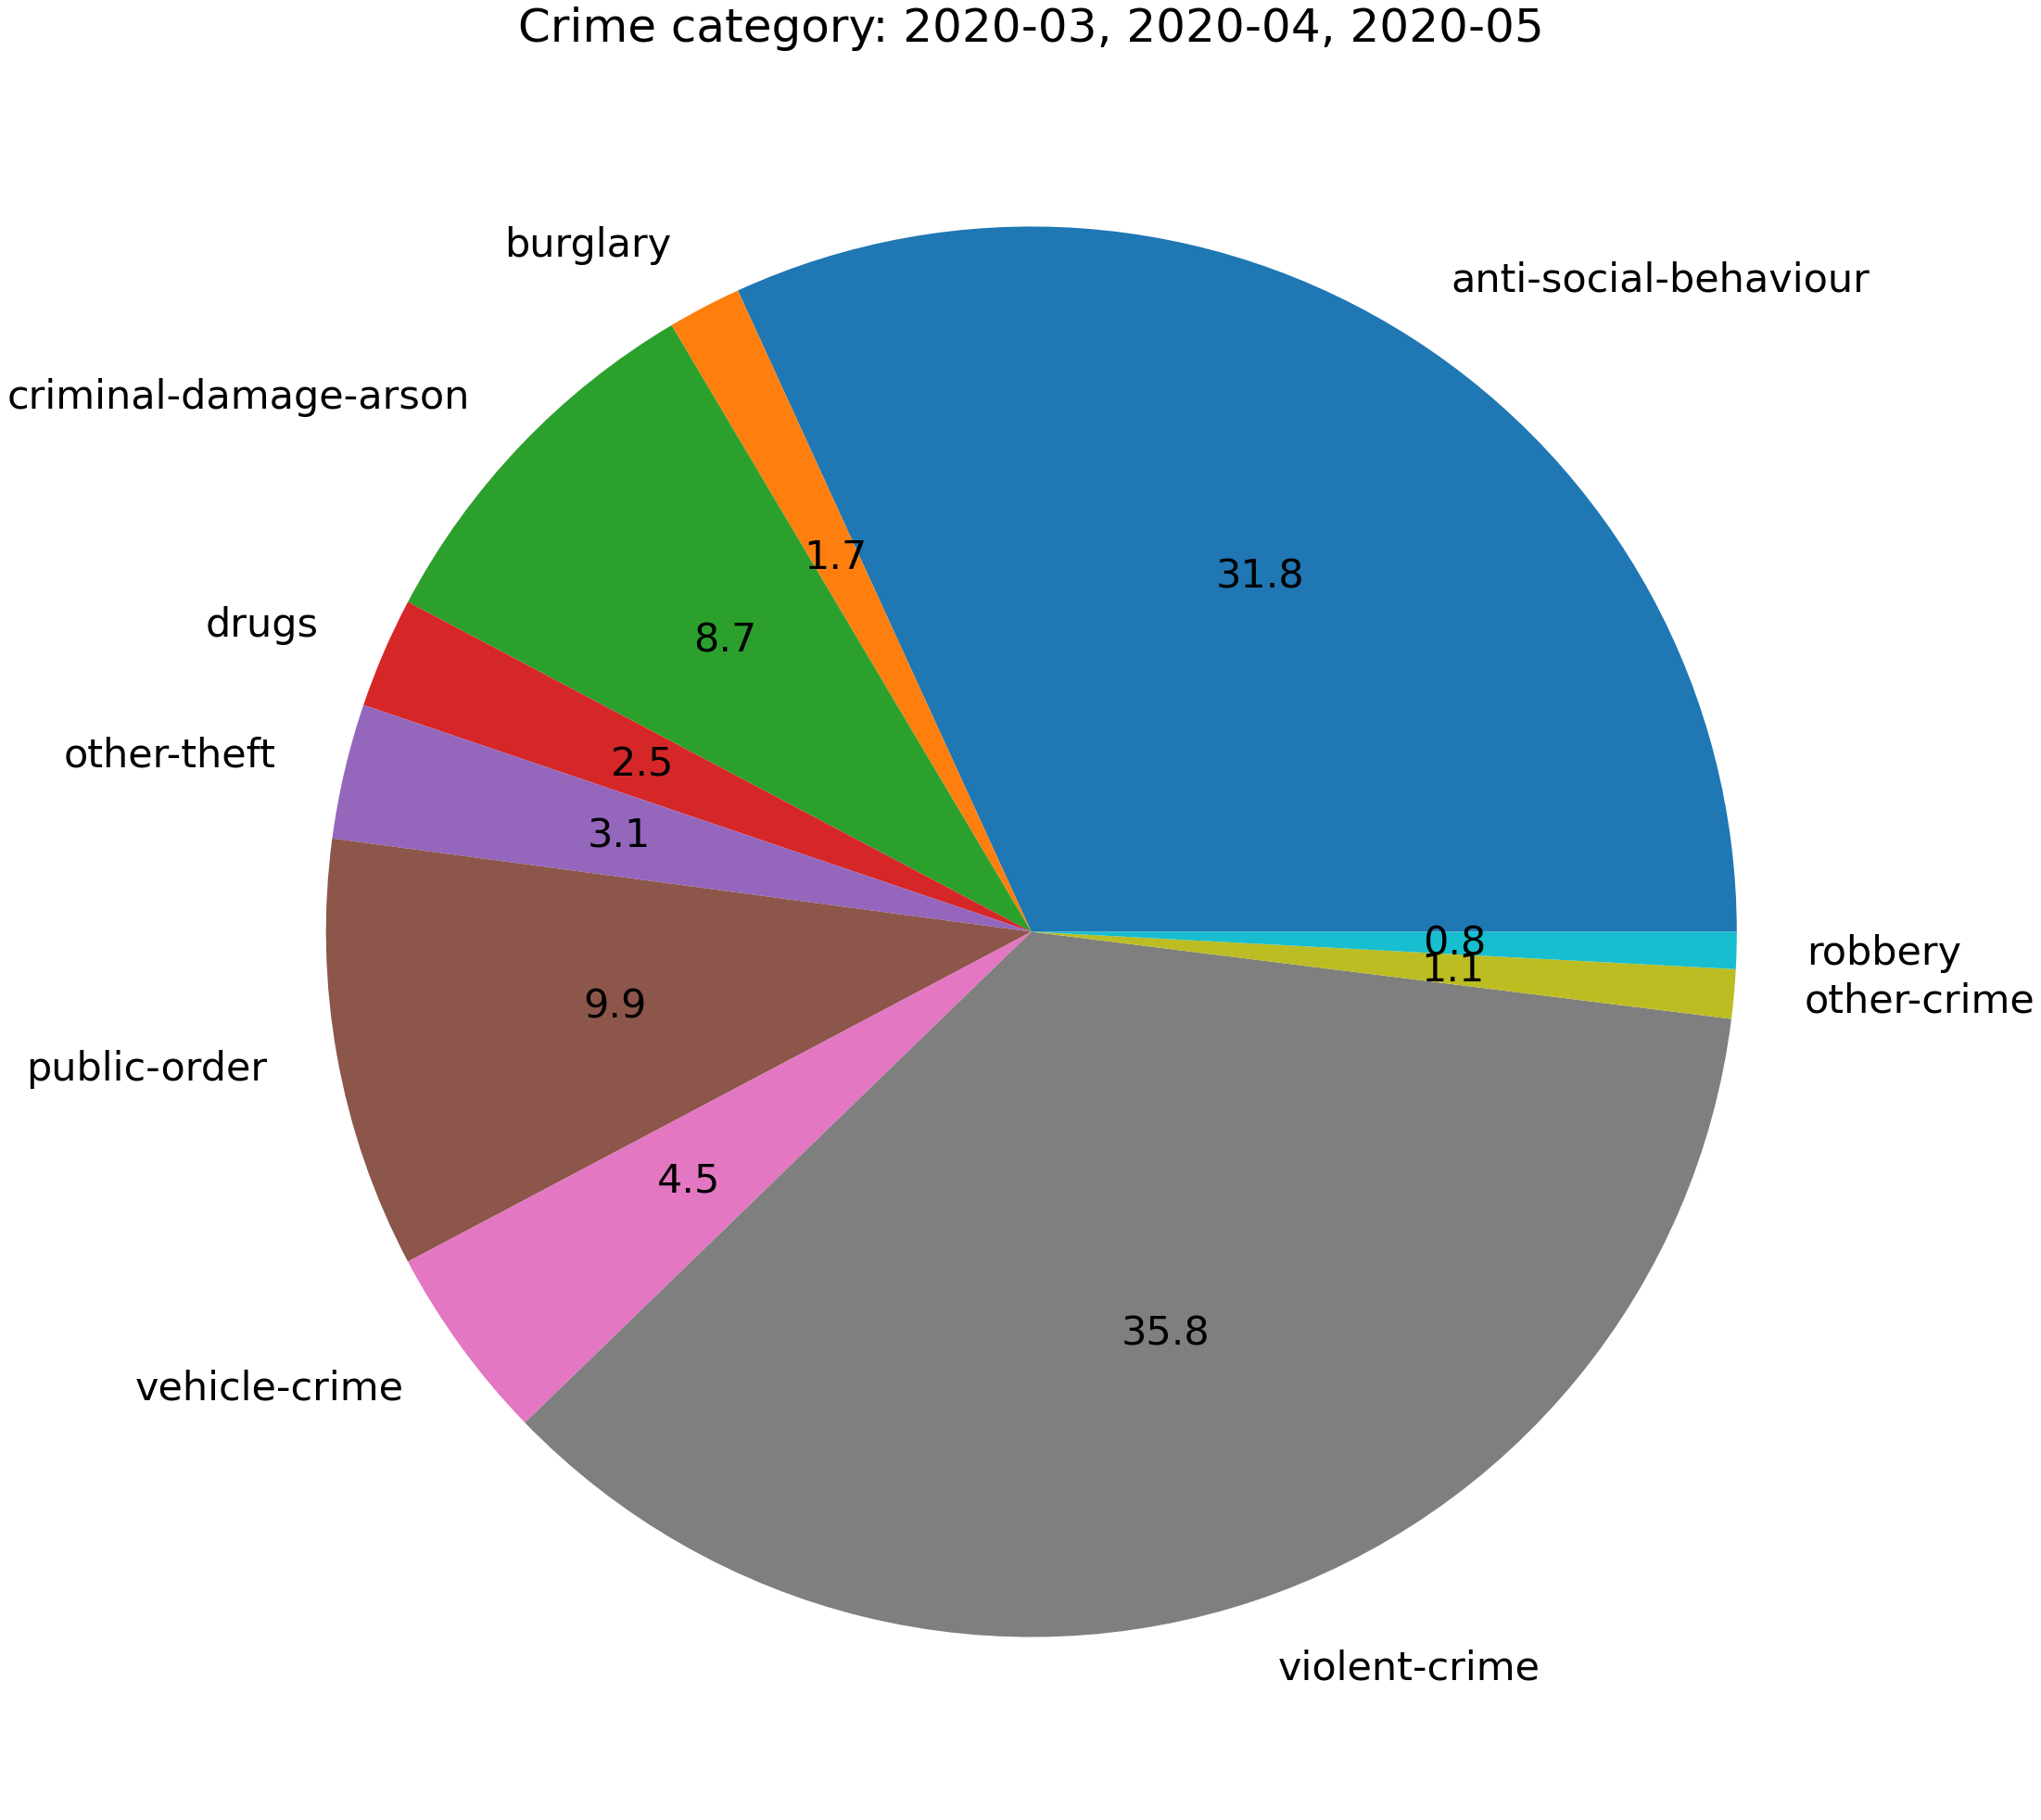

In [61]:
analytics_graph('2020-03','2020-04','2020-05','category')
